In [1]:
import swirl
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

from utils_mitgcm import open_mitgcm_ds_from_config

In [2]:
model = 'geneva_200m'

params_file = 'swirl_03'

# Open MITgcm results

In [3]:
mitgcm_config, ds_mitgcm = open_mitgcm_ds_from_config('../config.json', model)

# Select depth and time

In [4]:
depth_indices = [0]#range(len(ds_mitgcm.Z.values))
time_indices = [0]#range(len(ds_mitgcm.time.values))

# Run SWIRL

In [ ]:
def run_swirl(data_snapshot):
    u_plot = data_snapshot['UVEL'].values
    v_plot = data_snapshot['VVEL'].values
    u_plot = np.where(np.isnan(u_plot), 0, u_plot).T
    v_plot = np.where(np.isnan(v_plot), 0, v_plot).T
    dx = data_snapshot.dxC.values[0][0]
    dy = data_snapshot.dyC.values[0][0]
    
    vortices = swirl.Identification(v=[u_plot, v_plot],
                                   grid_dx=[dx, dy],
                                   param_file=f'./swirl_params/{params_file}.param',
                                   verbose=False)
    vortices.run()
    
    return vortices

In [ ]:
eddies = {
    'depth_indices': depth_indices,
    'time_indices': time_indices
}

# Loop through time and depth to compute eddies
for t_idx in time_indices:
    eddies[t_idx] = {
        d_idx: run_swirl(ds_mitgcm.isel(time=t_idx, Z=d_idx))
        for d_idx in depth_indices
    }

# Plot

In [26]:
def plot_map_swirl(snapshot, vortices, title, stream_density):
    # rortex
    plt.close('all')
    fig=plt.figure(figsize=(15,5))
    plt.imshow(vortices.rortex[0].T, cmap='PiYG', vmin=-0.001, vmax=0.001)
    plt.gca().invert_yaxis()
    cbar=plt.colorbar()
    cbar.set_label('Rortex R')
    
    # streamlines
    xgrid, ygrid = np.meshgrid(range(len(snapshot['XC'].values)), range(len(snapshot['YC'].values)))
    u_plot = snapshot['UVEL'].values
    v_plot = snapshot['VVEL'].values
    plt.streamplot(xgrid, ygrid, u_plot, v_plot, 
                   density=stream_density, color='black', linewidth=0.5, 
                   arrowsize=0.7, arrowstyle='->')
    
    # Extent
    for vortex in vortices:
        plt.scatter(vortex.vortex_cells[0], vortex.vortex_cells[1], s=0.2, c='blue')
        plt.scatter(vortex.center[0], vortex.center[1],marker='*', s=50, c='red', zorder=10)
    
    plt.text(0.02, 0.98, f'Z={round(float(snapshot.Z.values),2)}m', transform=plt.gca().transAxes, ha='left', va='top')
    plt.title(title)
    
    return fig

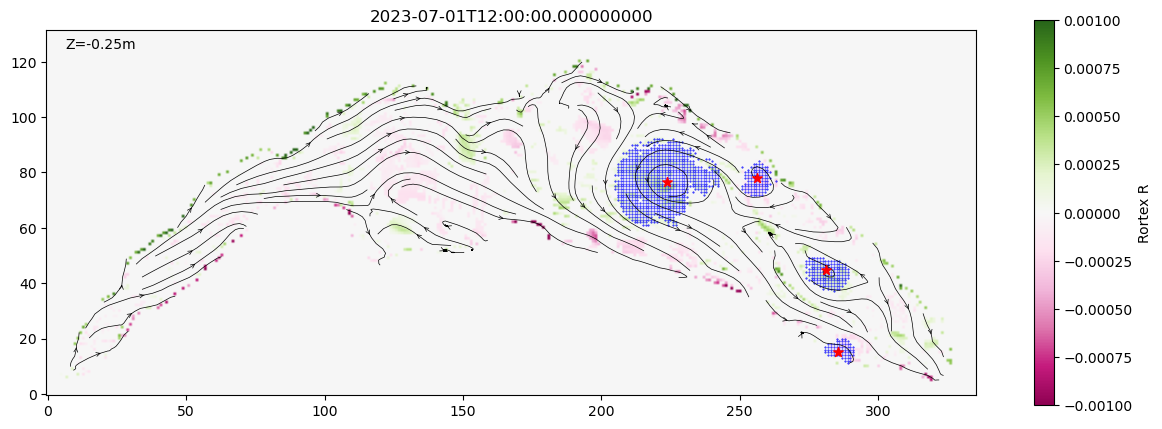

In [35]:
t_index = 0
d_index = 0
time=ds_mitgcm.isel(time=t_index).time.values
test=plot_map_swirl(ds_mitgcm.isel(time=t_index, Z=d_index), eddies[t_index][d_index], str(time), stream_density = 2)

# Save results

In [20]:
import pickle
# Save the eddies dictionary to a file
with open(r'../Outputs/test.pkl', 'wb') as f:
    pickle.dump(eddies, f)

### Eddie catalogue - level 0

In [ ]:
def compute_ke_snapshot(snapshot_vel):
    ke = 0.5 * (snapshot_vel.UVEL.values**2 + snapshot_vel.VVEL.values**2 + snapshot_vel.WVEL.values**2) * snapshot_vel.dxC.values * snapshot_vel.dyC.values * snapshot_vel.drC.values  # This gives J per cell
    
    return ke / 1e6  # Convert to MJ

In [ ]:
def translate_rotation_direction(eddy_orientation: int):
    return 'clockwise' if eddy_orientation == -1 else 'anticlockwise'       

In [ ]:
df_catalogue_level0 = pd.DataFrame(columns=[
    'id',
    'date',
    'depth_[m]',
    'xc',
    'yc',
    'surface_area_[m2]',
    'volume_slice_[m3]',
    'rotation_direction',
    'kinetic_energy_[MJ]'
])
id_level0 = 0
for t_index in eddies['time_indices']:
    for d_index in eddies['depth_indices']:
        snapshot_vel = ds_mitgcm.isel(time=t_index, Z=d_index, Zp1=d_index, Zl=d_index, Zu=d_index)
        snapshot_eddies = eddies[t_index][d_index]
        surface_cell = snapshot_vel.dxC.values[0][0] * snapshot_vel.dyC.values[0][0]
        ke_snapshot_megajoules = compute_ke_snapshot(snapshot_vel)
        for eddy in snapshot_eddies:
            print(f'Processing eddy {id_level0}')
            vortex_indices = tuple(eddy.vortex_cells.astype(int))
            ke_eddy = ke_snapshot_megajoules[vortex_indices[1], vortex_indices[0]].sum()
            surface_area = len(eddy.vortex_cells[0]) * surface_cell
            
            df_catalogue_level0.loc[id_level0] = [
                id_level0,                                                       # int
                pd.Timestamp(snapshot_vel.time.values).to_pydatetime(),          # datetime64 -> datetime.datetime
                float(snapshot_vel.Z.values),                                    # float
                eddy.center[0],                                                  # tuple
                eddy.center[1],
                float(surface_area),                                             # numpy.float32 -> float
                float(surface_area * float(snapshot_vel.drC.values)),            # volume
                translate_rotation_direction(eddy.orientation),                  # str
                float(ke_eddy)                                                   # numpy.float64 -> float
            ]
            id_level0 += 1

In [ ]:
df_catalogue_level0

In [ ]:
csv_path = r'../Outputs/df_catalogue_level0.csv'
df_catalogue_level0.to_csv(csv_path, index=False)

### Plots

In [ ]:
for d_plot in eddies['depth_indices']:
    for t_plot in eddies['time_indices']:
        time=ds_mitgcm.isel(time=t_plot).time.values
        fig = plot_map_swirl(ds_mitgcm.isel(time=t_plot, Z=d_plot), 
                              eddies[t_plot][d_plot], 
                              str(time),
                              6 # streamplot density (default=6)
                             )
        plt.savefig(rf'../Outputs/{params_file}_t{t_plot}_z{d_plot}.png')

### Snapshot

In [ ]:
t_save=0
snapshot_to_save = ds_mitgcm.isel(time=t_save)

Rortex

rortex_data = np.zeros([len(ds_mitgcm.Z.values), len(ds_mitgcm.YC.values), len(ds_mitgcm.XC.values)])*np.nan
for d_save in eddies['depth_indices']:
    rortex_data[d_save] = eddies[t_save][d_save].rortex[0].T

snapshot_to_save['rortex'] = xr.DataArray(
    data=rortex_data,
    dims=('Z', 'YC', 'XC'),
    name='Rortex'
)

snapshot_to_save['rortex'] = xr.where(
    snapshot_to_save['rortex'] == 0,
    np.nan,
    rortex_data    
)

snapshot_to_save['rortex'].isel(Z=0).plot(vmin=-0.001)

Vortex extent

In [ ]:
eddies_extent_data = np.zeros([len(ds_mitgcm.Z.values), len(ds_mitgcm.YC.values), len(ds_mitgcm.XC.values)])*np.nan
for d_save in eddies['depth_indices']:
    for eddy in eddies[t_save][d_save]:
        for i in range(len(eddy.vortex_cells[0])):
            eddies_extent_data[d_save][int(eddy.vortex_cells[1,i])][int(eddy.vortex_cells[0,i])] = 1

In [ ]:
snapshot_to_save['eddies_extent'] = xr.DataArray(
    data=eddies_extent_data,
    dims=('Z', 'YC', 'XC'),
    name='eddies_extent'
)

In [ ]:
snapshot_to_save['eddies_extent'].isel(Z=0).plot()

Vortex center

In [ ]:
eddies_center_data = np.zeros([len(ds_mitgcm.Z.values), len(ds_mitgcm.YC.values), len(ds_mitgcm.XC.values)])*np.nan
for d_save in eddies['depth_indices']:
    for eddy in eddies[t_save][d_save]:
        eddies_center_data[d_save][int(eddy.center[1])][int(eddy.center[0])] = 1

In [ ]:
snapshot_to_save['eddies_center'] = xr.DataArray(
    data=eddies_center_data,
    dims=('Z', 'YC', 'XC'),
    name='eddies_center'
)

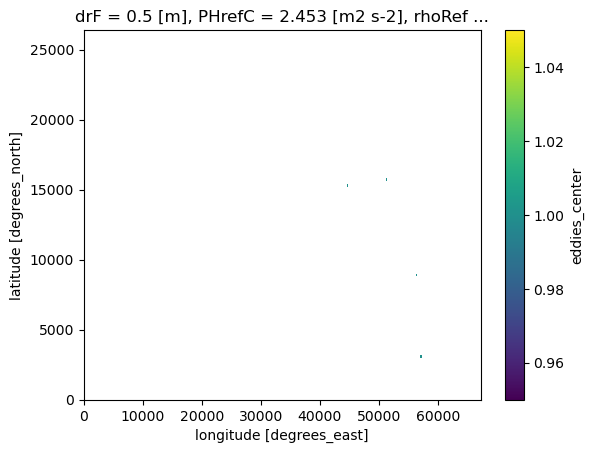

In [100]:
snapshot_to_save['eddies_center'].isel(Z=0).plot()

snapshot_to_save.to_netcdf(rf'../Outputs/{params_file}_t{t_save}.nc')